# K-means

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

from sklearn.datasets import make_blobs
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import KMeans

## Some constants

In [2]:
N_POINTS = 1000
N_CLUSTERS = 10
RANDOM_STATE = 0

## Visualization

In [3]:
def plot_clusters(data, color=None, centers=None, max_dots=1000,
                  plot_pos=(1, 1, 1), title=None, legend=False):
    ax = plt.subplot(*plot_pos)
    ax.set_aspect('equal')
    ax.set_title(title)
    
    positions = np.arange(data.shape[0])
    if data.shape[0] > max_dots:
        np.random.shuffle(positions)
        positions = positions[:max_dots]

    scatter = ax.scatter(data[positions, 0], data[positions, 1], c= None if
                         color is None else color[positions])
    if legend:
        legend = ax.legend(*scatter.legend_elements(), loc='best')
        legend.get_frame().set_alpha(0.3)
        ax.add_artist(legend)

    if not centers is None:
        plt.scatter(centers[:, 0], centers[:, 1], lw=3, c='red')

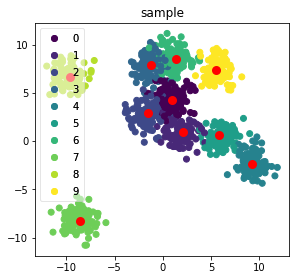

In [4]:
plt.figure(figsize=(10, 10))
X, y, centers = make_blobs(n_samples=N_POINTS, n_features=2, centers=N_CLUSTERS, random_state=0, return_centers=True)
plot_clusters(X, y, centers, plot_pos=(1, 2, 1), title='sample', legend=True)

## KMeans implementation

In [5]:
 class MyKMeans():
    def __init__(self, n_clusters, init='uniform', random_state=None, precision=0.001):
        self.n_clusters = n_clusters
        self.init = init
        self.random_state = random_state
        self.precision = precision
    
    def init_centers(self, data):
        if not self.random_state is None:
            np.random.seed(self.random_state) 
        
        if self.init == 'uniform':
            min_val = np.min(data, axis=0)
            max_val = np.max(data, axis=0)
            return min_val + (max_val - min_val) * np.random.rand(self.n_clusters, data.shape[1])

        elif self.init == 'max_distance':
            """Not kmeans++, every time choose point that has maximum min
            distance to centers
            """
            centers = [data[np.random.randint(0, data.shape[0] - 1)]]
            min_to_center = np.full(data.shape[0], np.inf)
            for i in range(self.n_clusters - 1):
                dist_from_last = np.sum(np.square(data - centers[-1]), axis=1)
                min_to_center = np.minimum(min_to_center, dist_from_last)
                next_c = data[np.argmax(min_to_center)]
                centers.append(next_c)
            return np.array(centers)          

    def predict(self, data):
        self.centers = self.init_centers(data)
        history = [np.inf]
        clust_nums = None
        while True:
            dist_from_centers = np.sum(np.square(data - self.centers[:, np.newaxis]), axis=2)
            loss = np.sum(np.min(dist_from_centers, axis=0))
            history.append(loss)
            clust_nums = np.argmin(dist_from_centers, axis=0)
            centers_old = np.copy(self.centers.copy())
            for i in range(self.n_clusters):
                numbers = clust_nums == i
                if numbers.any():
                    self.centers[i] = np.mean(data[numbers], axis=0)
            if (((self.centers - centers_old) ** 2).sum() < self.precision):
                break
        self.history = history 
        return clust_nums, self.centers

## Loss function (MCR)

In [6]:
def mean_clust_radius(X, y, centers):
    """Sum of mean distances from cluster center to it's points for
    all clusters.
    
    Shows how big distances between points in one cluster are.
    """

    res = np.sum(
        [
            np.mean(np.sum(np.square(X[y == i] - centers[i]), axis=1)) if np.any(y == i)
            else 0 # cluster without dots
            for i in range(centers.shape[0])
        ]
    )
    return res

## Some random inputs

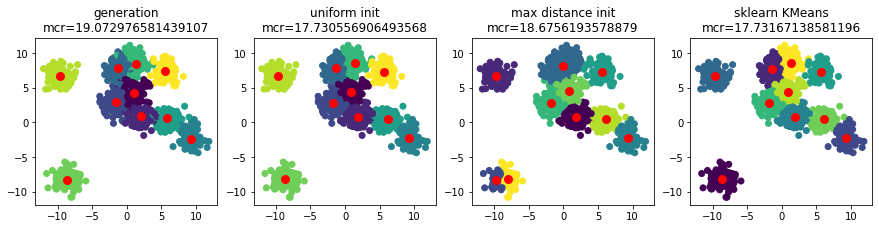

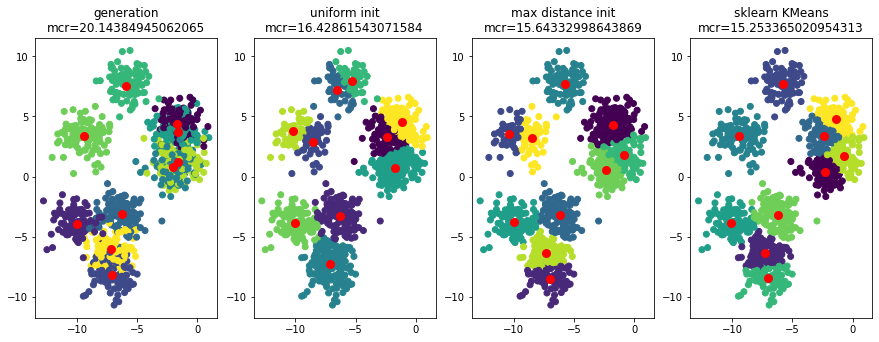

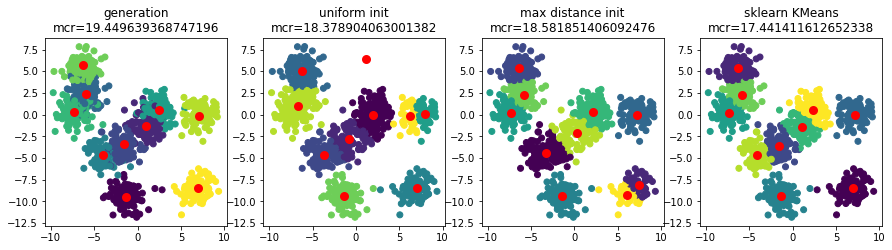

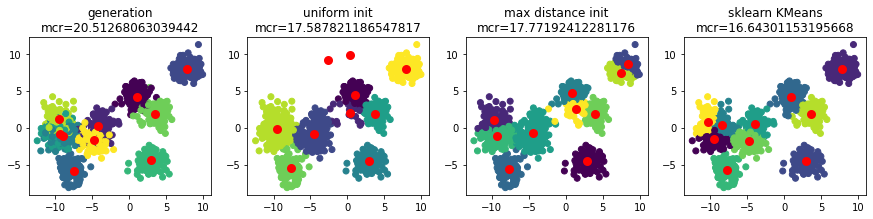

In [7]:
for i in range(4):
    plt.figure(figsize=(15, 15))
    # generation
    X, y, centers = make_blobs(n_samples=N_POINTS, n_features=2, centers=N_CLUSTERS,
                               random_state=i, return_centers=True)
    mcr = mean_clust_radius(X, y, centers)
    plot_clusters(X, y, centers, plot_pos=(1, 4, 1), title=f'generation\nmcr={mcr}')
    # uniform init
    myKMeans = MyKMeans(n_clusters=N_CLUSTERS, init='uniform', random_state=RANDOM_STATE)
    y_pred, c_pred = myKMeans.predict(X)
    mcr = mean_clust_radius(X, y_pred, c_pred)
    plot_clusters(X, y_pred, c_pred, plot_pos=(1, 4, 2), title=f'uniform init\nmcr={mcr}')
    # max distance init
    myKMeans = MyKMeans(n_clusters=N_CLUSTERS, init='max_distance', random_state=RANDOM_STATE)
    y_pred, c_pred = myKMeans.predict(X)
    mcr = mean_clust_radius(X, y_pred, c_pred)
    plot_clusters(X, y_pred, c_pred, plot_pos=(1, 4, 3), title=f'max distance init\nmcr={mcr}') 
    # sklearn KMeans
    sk_KMeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
    y_pred = sk_KMeans.fit_predict(X)
    c_pred = sk_KMeans.cluster_centers_
    mcr = mean_clust_radius(X, y_pred, c_pred)
    plot_clusters(X, y_pred, c_pred, plot_pos=(1, 4, 4), title=f'sklearn KMeans\nmcr={mcr}')

## Choosing number of clusters

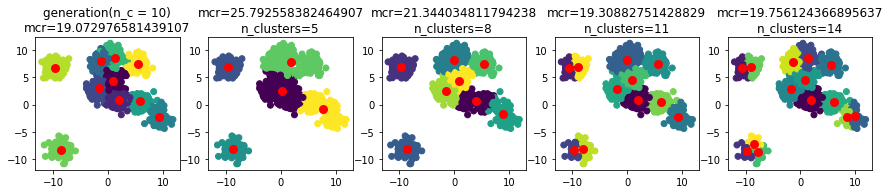

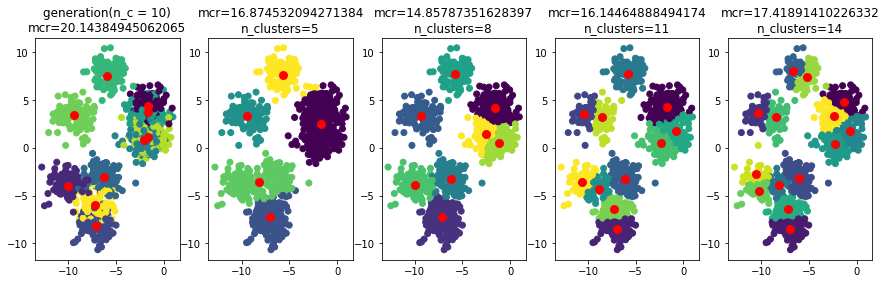

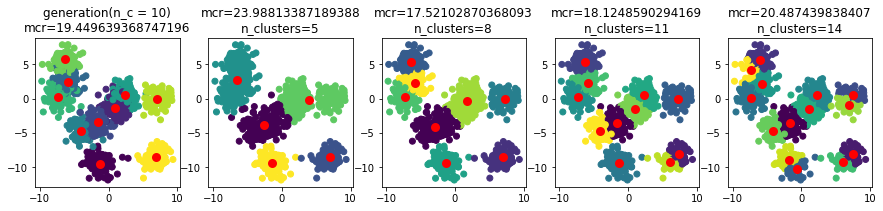

In [8]:
clust_gen = 10
clust_grid = [5, 8, 11, 14]

for i in range(3):
    plt.figure(figsize=(15, 15))
    # generation
    X, y, centers = make_blobs(n_samples=N_POINTS, n_features=2, centers=clust_gen,
                               random_state=i, return_centers=True)
    mcr = mean_clust_radius(X, y, centers)
    plot_clusters(X, y, centers, plot_pos=(1, len(clust_grid) + 1, 1),
                  title= f'generation(n_c = {clust_gen})\nmcr={mcr}')
    # uniform init
    for j, n_clust in enumerate(clust_grid):
        myKMeans = MyKMeans(n_clusters=n_clust, init='max_distance', random_state=RANDOM_STATE)
        y_pred, c_pred = myKMeans.predict(X)
        mcr = mean_clust_radius(X, y_pred, c_pred)
        plot_clusters(X, y_pred, c_pred, plot_pos=(1, len(clust_grid) + 1, j + 2),
                      title=f'mcr={mcr}\nn_clusters={n_clust}')

#### What can we see?
MCR (sum of Mean Cluster Radii) helps to find appropriate number of
clusters. Although for example in first row n_clusters=8 looks better
than 11. So it may be relevant to prefer less number of clusters when
it changes MCR a little.
Also sometimes blobs in generation overlap each other and two blobs
could be related to one cluster.

In [9]:
def grid_estim(n_clusters_grid, X):
    mcr_list = []
    for n_clust in n_clusters_grid:
        myKMeans = MyKMeans(n_clusters=n_clust, init='max_distance', random_state=RANDOM_STATE)
        y_pred, c_pred = myKMeans.predict(X)
        mcr = mean_clust_radius(X, y_pred, c_pred)
        mcr_list.append(mcr)
    return mcr_list

minimum when n_clusters = 7


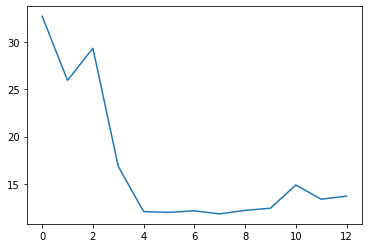

In [10]:
clust_gen = 7
clust_grid = list(range(13))

X, y, centers = make_blobs(n_samples=N_POINTS, n_features=2, centers=clust_gen,
                           random_state=i, return_centers=True)

mcr_list = grid_estim(clust_grid, X)

plt.plot(mcr_list)
print(f'minimum when n_clusters = {clust_grid[np.argmin(mcr_list)]}');

#### Does it always work so good?
No. With _clust_gen = 8_ minimum in 5 and with _clust_gen = 9_ in 8

## Check time

In [11]:
n_points_grid = [100, 1000, 10000, 100000]
n_clusters_grid = [5, 10, 15, 20]

res_matrix = []
for n_points in n_points_grid:
    matrix_line = []
    for n_clusters in n_clusters_grid:
        time_vals = []
        for random_state in range(3):
            X, y, centers = make_blobs(n_samples=n_points, n_features=2, centers=n_clusters,
                                       random_state=random_state, return_centers=True)
            myKMeans = MyKMeans(n_clusters=n_clusters, init='max_distance',
                                random_state=random_state)
            start_time = time()
            myKMeans.predict(X)
            time_vals.append(time() - start_time)
        matrix_line.append(np.mean(time_vals))
    res_matrix.append(matrix_line)

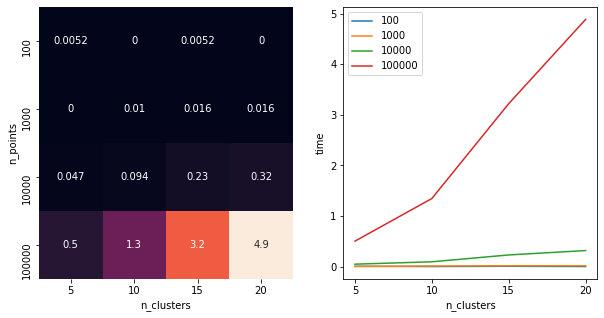

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ax = sns.heatmap(res_matrix, annot=True, cbar=False)
ax.set(xlabel="n_clusters", ylabel = "n_points", 
       xticklabels=n_clusters_grid, yticklabels=n_points_grid)

ax = plt.subplot(1, 2, 2)
for i, n_p in enumerate(n_points_grid):
    ax.plot(res_matrix[i], label=n_p)
    ax.set(xlabel="n_clusters", ylabel = "time", xticks=range(4), xticklabels=n_clusters_grid)
ax.legend();

## Distances visualization

In [13]:
def distance_matrix(X, y):
    sorted_X = X[np.argsort(y)]
    matrix = np.sum(np.square(sorted_X - sorted_X[:,np.newaxis]), axis=2)
    return matrix

In [14]:
def cluster_distance_matrix(X, y):
    n_clusters = len(np.unique(y))
    clusters = [X[y == i] for i in range(n_clusters)] 
    matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            matrix[i, j] = np.mean(
                np.sum(np.square(clusters[i] - clusters[j][:,np.newaxis]), axis=2)
            )
    return matrix

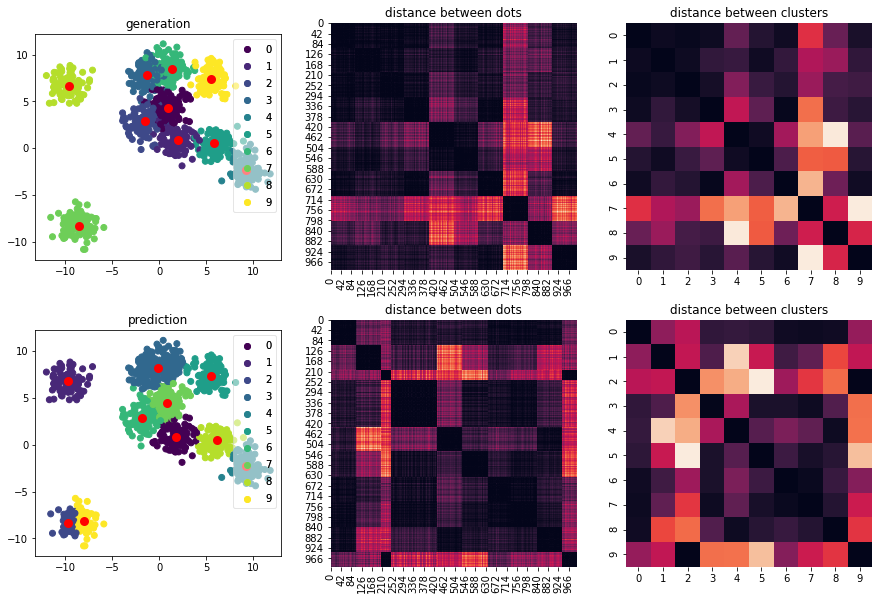

In [15]:
plt.figure(figsize=(15, 10))
# generation
X, y, centers = make_blobs(n_samples=N_POINTS, n_features=2, centers=N_CLUSTERS,
                           random_state=RANDOM_STATE, return_centers=True)

plot_clusters(X, y, centers, plot_pos=(2, 3, 1), legend=True, title='generation')
plt.subplot(2, 3, 2)
dm = distance_matrix(X, y)
ax = sns.heatmap(dm, cbar=False)
ax.set_title('distance between dots')
plt.subplot(2, 3, 3)
dm = cluster_distance_matrix(X, y)
ax = sns.heatmap(dm, cbar=False)
ax.set_title('distance between clusters')


myKMeans = MyKMeans(n_clusters=N_CLUSTERS, init='max_distance', random_state=RANDOM_STATE)
y_pred, c_pred = myKMeans.predict(X)

plot_clusters(X, y_pred, c_pred, plot_pos=(2, 3, 4), legend=True, title='prediction')
plt.subplot(2, 3, 5)
dm = distance_matrix(X, y_pred)
ax = sns.heatmap(dm, cbar=False)
ax.set_title('distance between dots')
plt.subplot(2, 3, 6)
dm = cluster_distance_matrix(X, y_pred)
ax = sns.heatmap(dm, cbar=False)
ax.set_title('distance between clusters');

#### Annotation
I can't understand anything from these heatmaps but they look cool